# Massachusetts School Staff Demographics

The goal of our project is to better understand the characteristics of public K-12 schools in Massachusetts that have high rates of nonwhite staff members. 

Before exploring the questions in our proposal, we created a dataframe the combined several of our master files from the DESE website: staff race/ethnicity, student race/ethnicity, student enrollment, and school addreses. 

In [783]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [784]:
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])

In [785]:
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})
staff = staff.rename(columns={"FTE Count": "Total Staff"})
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])
students['Nonwhite (Num Stu)'] = students["Total Students"] - (round(students['White']/100 * students['Total Students'], 0))
staff['Nonwhite (Num Staff)'] = staff["Total Staff"] - staff["White (# )"]

The inner join with addresses drops schools that have been closed between 2010 and 2015, since the addresses file only contains information for schools that are currently open. Schools that the state decides to close may have different characteristics than currently operating schools, so we were comfortable dropping records for closed schools. 

In [786]:
df = pd.merge(students, staff, how= "left", on= ['Org Code','Year'])
df = pd.merge(df, addresses, how= "inner", on = "Org Code")
df = df[["Org Code", "Org Name", "Org Type", "Year", "Job Category", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff", "Zip Code"]]

Before starting our exploration, we removed State Totals (Org Code = 0) and dropped a 2015 record that reported 0 total staff for the year.

In [787]:
df_mask = df["Org Code"] != 0
df_mask &= df["Total Staff"] > 0
df = df[df_mask]

## What is the breakdown of staff race/ethnicity within the following school employee roles in Massachusetts: principal, administrator, teacher, and support staff?

### What are the trends in student and staff populations over time?

We first plotted the percentages of non-white staff and students over time. We found that the percent of nonwhite staff has remained flat over the past 6 years, hovering between 7.8-8.2%, while the percent of nonwhite students has increased by approximately 1% each year, from 30.3% of students in 2010 to 36.1% of students in 2015. 

In [788]:
year_grouped = df.groupby(["Year"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff"]]

In [789]:
year_grouped['Perc Nonwhite Students'] = round(year_grouped['Nonwhite (Num Stu)'] / year_grouped['Total Students'] * 100, 2)
year_grouped['Perc Nonwhite Staff'] = round(year_grouped['Nonwhite (Num Staff)'] / year_grouped['Total Staff'] * 100, 2)
year_grouped = year_grouped.reset_index()
year_grouped.set_index("Year")

,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Perc Nonwhite Students,Perc Nonwhite Staff
Year,,,,,,
2010,2133733.0,7153304,17104.2,218152.3,29.83,7.84
2011,2213553.0,7195927,17037.3,216760.7,30.76,7.86
2012,2288348.0,7221255,17652.0,220492.8,31.69,8.01
2013,2390007.0,7275045,18382.4,225406.6,32.85,8.16
2014,2449215.0,7279011,18157.4,229304.4,33.65,7.92
2015,2622886.0,7422813,19252.7,235502.0,35.34,8.18


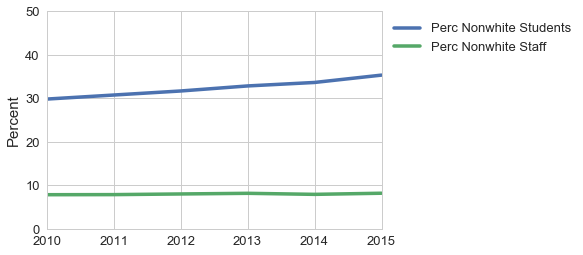

In [790]:
sns.set_style("whitegrid")
ax = year_grouped[['Year', 'Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot(linewidth=3.5)
ax.set_ylim(ymin = 0, ymax = 50)
ax.set_ylabel('Percent', fontsize=15)
ax.set_xlabel("")
ax.tick_params(labelsize=13)
ax.legend(bbox_to_anchor=(1.6,1), loc="upper right", prop={'size': 13});

Since fewer than 10% of staff members in Massachusetts schools are nonwhite, we decided not to differentiate between different nonwhite ethnic and racial groups in our analysis.

### What is the breakdown of nonwhite staff members within different school roles in Massachusetts?

We explored the average percent of nonwhite staff in every job category from 2010 to 2015. Although nonwhite staff members have comprised 8% of school staff employees on average, a higher percentage of nonwhite employees are Paraprofessionals (11.7%) or Administrative Support (9.5%) than Teachers (6.8%). Encouragingly, 10.8% of school leaders report as nonwhite. We wanted to explore this as a potential contributing factor to schools that have higher percentages of nonwhite staff, as Massachusetts school leaders are generally the decision makers for hiring and school culture. 

In [791]:
df_jobs_grouped = df.groupby("Job Category").sum()[["Nonwhite (Num Staff)", "Total Staff"]]
df_jobs_grouped["% Nonwhite Staff"] = round(df_jobs_grouped["Nonwhite (Num Staff)"] / df_jobs_grouped["Total Staff"] * 100, 2)
df_jobs_grouped.reset_index()

,Job Category,Nonwhite (Num Staff),Total Staff,% Nonwhite Staff
0,Administrative Support,3193.9,33462.1,9.54
1,All Staff,53788.7,672689.1,8.00
2,District Leaders,154.4,2115.9,7.30
3,Health,507.6,10840.0,4.68
4,Paraprofessionals,15512.2,132788.5,11.68
5,Related Service Providers,678.8,19189.8,3.54
6,School Leaders,2716.3,25111.6,10.82
7,Student Support,3058.4,37248.8,8.21
8,Teachers,27975.7,412173.0,6.79


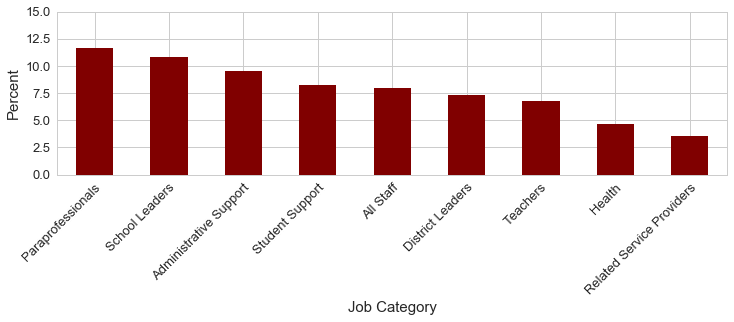

In [792]:
sns.set_style("whitegrid")
job = df_jobs_grouped["% Nonwhite Staff"].sort_values(ascending = False).plot(kind = "bar", color = "maroon", figsize = (12, 3))
job.set_ylim(ymin = 0, ymax = 15)
job.set_ylabel('Percent', fontsize=15)
job.tick_params(labelsize=13)
job.set_xlabel("Job Category", fontsize = 15)
job.set_xticklabels(job.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor');

## What characteristics do schools with high percentages of nonwhite staff members share?

### Is there a correlation between the percent of nonwhite students and percent of nonwhite staff in schools?

One of our hypotheses is that schools with higher percentages of nonwhite students will also have higher percentages of nonwhite staff. We looked at the correlation between percent of nonwhite students and percents of nonwhite staff for each year between 2010 and 2015:

In [793]:
df['Perc Nonwhite Students'] = df['Nonwhite (Num Stu)'] / df['Total Students'] * 100
df['Perc Nonwhite Staff'] = df['Nonwhite (Num Staff)'] / df['Total Staff'] * 100

In [794]:
all_staff_mask = df["Job Category"] == "All Staff"
df_staff = df[all_staff_mask]
df_staff.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Zip Code,Perc Nonwhite Students,Perc Nonwhite Staff
0,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,All Staff,913.0,1426,3.0,145.7,01606,64.025245,2.059025
9,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2011,All Staff,941.0,1426,4.0,151.7,01606,65.988780,2.636783
18,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2012,All Staff,963.0,1426,6.6,146.3,01606,67.531557,4.511278
27,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2013,All Staff,995.0,1426,7.5,154.3,01606,69.775596,4.860661
36,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2014,All Staff,1051.0,1426,7.6,157.3,01606,73.702665,4.831532


We saw that the correlation coefficient, while over .70 each year, has declined between 2010 and 2015. We also know that the current percentage of nonwhite students in MA schools is closer to the 2015 number than the 2010 number. For these reasons, we continued our analysis with just 2015 data to see what other factors are associated with higher percentages of nonwhite staff.

2010 rvalue: 0.777208556815 | pvalue: 0.0
2011 rvalue: 0.779424281375 | pvalue: 0.0
2012 rvalue: 0.755003345197 | pvalue: 2.7963636805e-316
2013 rvalue: 0.746471159142 | pvalue: 1.15225372594e-310
2014 rvalue: 0.716297195369 | pvalue: 3.22437633099e-279
2015 rvalue: 0.707250395781 | pvalue: 1.54131338763e-273


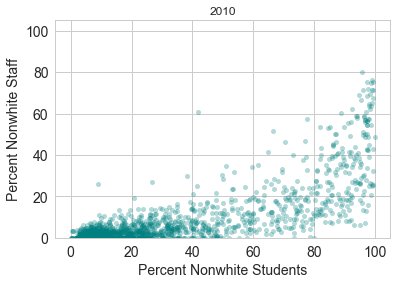

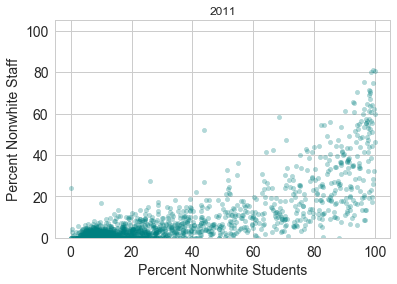

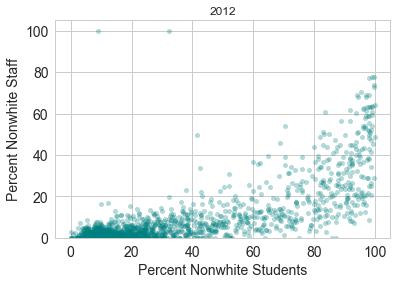

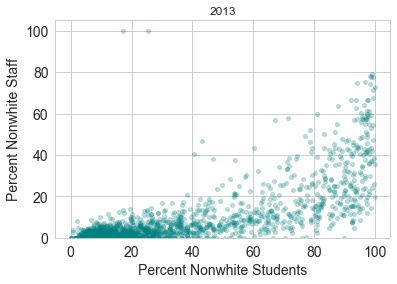

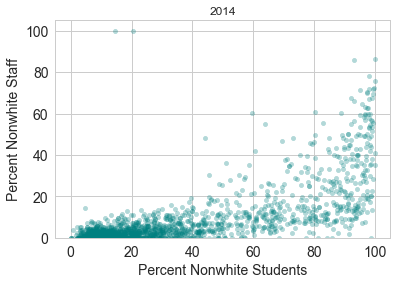

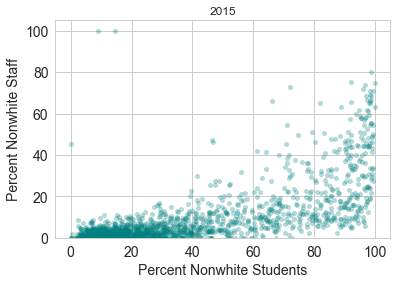

In [795]:
years = list(set(df_staff["Year"]))

for y in years:
    y_mask = df_staff["Year"] == y
    df_yr = df_staff[y_mask]
    r = stats.pearsonr(df_yr["Perc Nonwhite Students"], df_yr["Perc Nonwhite Staff"])
    p = df_yr.plot("Perc Nonwhite Students", "Perc Nonwhite Staff", kind = "scatter", color = 'teal', alpha = 0.3, title = y, fontsize = 14)
    p.set_xlabel('Percent Nonwhite Students', fontsize=14)
    p.set_ylabel('Percent Nonwhite Staff', fontsize=14)
    p.set_ylim(ymin = 0, ymax = 105)
    print(y, "rvalue:", r[0],"|", "pvalue:", r[1])
    p

In [858]:
mask_15 = df_staff["Year"] == 2015
df_staff_15 = df_staff[mask_15]
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Zip Code,Perc Nonwhite Students,Perc Nonwhite Staff
45,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2015,All Staff,1071.0,1428,7.6,163.6,01606,75.000000,4.645477
99,10505,Abington: Abington High,Public School,2015,All Staff,55.0,477,3.0,59.5,02351,11.530398,5.042017
153,10405,Abington: Abington Middle School,Public School,2015,All Staff,28.0,305,1.0,37.0,02351,9.180328,2.702703
207,10015,Abington: Woodsdale Elementary School,Public School,2015,All Staff,26.0,330,1.0,32.1,02351,7.878788,3.115265
261,4120530,Academy Of the Pacific Rim Charter Public (Dis...,Charter School,2015,All Staff,437.0,519,10.0,55.5,02136,84.200385,18.018018


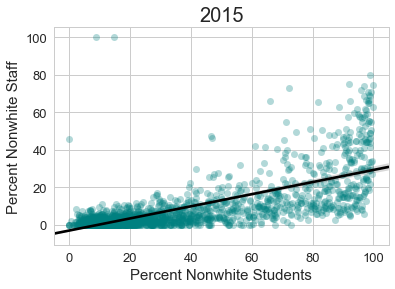

In [797]:
sns.set_style("whitegrid", rc={'axes.linewidth': 1})
p = sns.regplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_staff_15, scatter_kws = {"color": "teal", "alpha" : 0.3,}, line_kws = {"color": "black"})
p.set_ylabel('Percent Nonwhite Staff', fontsize=15)
p.set_xlabel("Percent Nonwhite Students", fontsize=15)
p.set_title("2015", fontsize=20)
p.tick_params(labelsize=13);

We looked at a few other factors that we believed would have an impact on the percent of nonwhite staff in a school to prepare for building our model. 

### Nonwhite school leaders

To look at the relationship between the percent of nonwhite staff and the presence of a nonwhite school leader, we make a school leader True/False indicator in our data frame. 

In [859]:
sl_mask = df["Year"] == 2015
sl_mask &= df["Job Category"] == "School Leaders"
school_leaders = df[sl_mask]

In [860]:
school_leaders["Nonwhite Leader"] = school_leaders['Perc Nonwhite Staff'] > 0.0

C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [861]:
school_leaders = school_leaders[["Org Code","Nonwhite Leader"]].set_index("Org Code")
df_staff_15 = df_staff_15.set_index("Org Code")
df_staff_15 = df_staff_15.join(school_leaders)
df_staff_15["Nonwhite Leader"] = df_staff_15["Nonwhite Leader"].fillna(0)

Schools with a nonwhite leader had a higher median percent of nonwhite staff, but there were many outliers for schools without a nonwhite leader. 

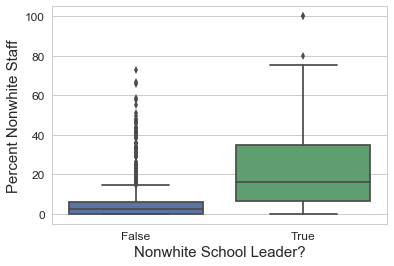

In [862]:
sl = sns.boxplot(x="Nonwhite Leader", y="Perc Nonwhite Staff", data=df_staff_15)
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("Nonwhite School Leader?", fontsize = 15);

When we updated our scatterplot to show schools with and without a nonwhite leader, the trend line for schools with a nonwhite leader had a steeper slope than schools with all white leaders. This was especially pronounced in schools with higher percentages of nonwhite students. 

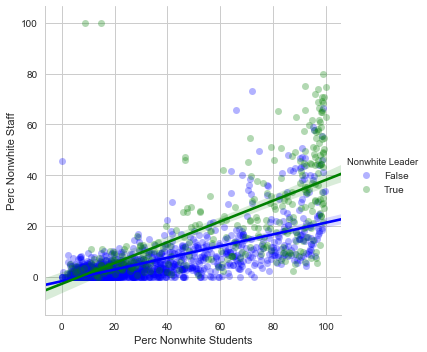

In [863]:
sc = sns.lmplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_staff_15, hue="Nonwhite Leader", palette = ["blue", "green"], scatter_kws = {"alpha" : 0.3,})

### Public versus charter schools

We looked at school type as a contributor to the percentage of nonwhite staff in schools next, because many Massachusetts charter schools serve nonwhite students. In a boxplot, we saw that charter schools have a higher median percentage of nonwhite staff. However, it is not possible to tell whether this is due to the school type or factors such as the location of the school. We decided to include Org Type in our model for further exploration.

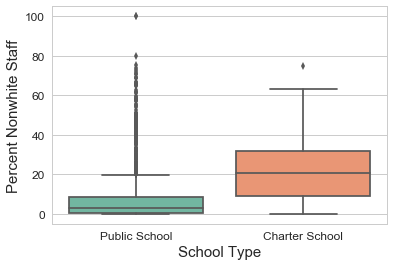

In [864]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=df_staff_15, palette="Set2", order = ["Public School", "Charter School"])
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

### American Community Survey Data

Before running our regression, we wanted to bring a few ACS variables into our data frame: median income, percent of households in poverty with an 18-year-old child or younger, percent of high school graduates, percent of college graduates, and percent nonwhite residents by zip code. Our ACS check-out file is located HERE.

In [865]:
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates", "Zip Perc White"])

In [866]:
acs = acs.replace('-', np.NaN)
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')
acs["Percent Nonwhite Residents"] = 100 - acs["Zip Perc White"]

In [867]:
acs = acs.set_index("Zip Code")
acs.head()

,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,
01001,60161.0,7.1,91.5,28.0,91.8,8.2
01002,50540.0,14.7,95.6,68.0,78.4,21.6
01005,68786.0,2.6,95.7,24.0,97.3,2.7
01007,76881.0,8.5,92.4,42.0,94.9,5.1
01010,87961.0,0.0,94.0,41.6,100.0,0.0


In [868]:
df_staff_15 = df_staff_15.reset_index().set_index("Zip Code")
df_staff_15 = df_staff_15.join(acs)
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Perc Nonwhite Students,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,,,,,,,,,,,,,
01001,50003,Agawam: Agawam Early Childhood Center,Public School,2015,All Staff,11.0,165,2.0,43.5,6.666667,4.597701,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50505,Agawam: Agawam High,Public School,2015,All Staff,141.0,1280,1.1,138.2,11.015625,0.795948,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50303,Agawam: Roberta G. Doering School,Public School,2015,All Staff,78.0,590,3.2,80.5,13.220339,3.975155,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50020,Agawam: Benjamin J Phelps,Public School,2015,All Staff,54.0,406,0.2,52.1,13.300493,0.383877,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50030,Agawam: James Clark School,Public School,2015,All Staff,50.0,332,0.1,54.2,15.060241,0.184502,False,60161.0,7.1,91.5,28.0,91.8,8.2


### 'In Boston' Indicator

Massachusetts is fairly segregated, particularly in the suburbs, so we believe that the location of a school could have an impact on its percentage of nonwhite staff. We included zip code as a categorical variable the first time we ran our regression, but including the 428 distinct zip codes seemed excessive. When examining the residuals, we noticed that many of the zip codes with the highest coefficients were those in Boston, so we created an 'In Boston' indicator for our model.

In [869]:
boston_zip = ['02111', '02113', '02115', '02116', '02118', '02119', '02120', '02121', '02122', '02124', '02125', '02126', '02127',
'02128', '02129', '02130', '02131', '02132', '02134', '02135', '02136', '02215']

boston_flag = ["Boston" for x in boston_zip]
boston = pd.DataFrame({'Zip Code': boston_zip, 'In Boston': boston_flag})

In [870]:
df_staff_15 = df_staff_15.reset_index()

In [871]:
df_staff_15 = pd.merge(df_staff_15, boston, how = "left", on = "Zip Code")

In [872]:
df_staff_15["In Boston"] = df_staff_15["In Boston"].fillna("Not Boston")
df_staff_15["In Boston"] = pd.Categorical(df_staff_15["In Boston"], categories=["Not Boston", "Boston"], ordered=True)

Boston schools tend to have higher percentages of nonwhite students and staff members. The difference between the percentage of nonwhite staff members is much more pronounced when comparing Boston and Non-Boston schools versus comparing public schools and charters. 

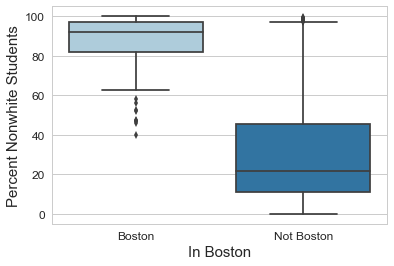

In [873]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Students", data=df_staff_15, palette="Paired", order = ["Boston", "Not Boston"])
boston.set_ylabel('Percent Nonwhite Students', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_xlabel("In Boston", fontsize = 15);

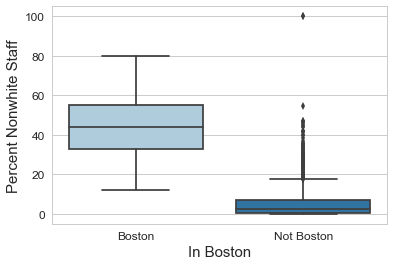

In [874]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Staff", data=df_staff_15, palette="Paired", order = ["Boston", "Not Boston"])
boston.set_ylabel('Percent Nonwhite Staff', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_xlabel("In Boston", fontsize = 15);

### Regression: All Schools

Before running our model, we dropped 6 records that were missing ACS data:

In [875]:
df_staff_15 = df_staff_15.dropna(subset = ['Percent Poverty', '% HS Graduates', 'Percent Nonwhite Residents'])

The first model we ran had an R-squared of 0.749. We removed % College Graduates and Median Income, as both had high p-valued and didn't contribute to our R-squared. 

The results show that several variables were significant: the presence of a nonwhite school leader, the location of a school in Boston, higher percentages of nonwhite students, higher student enrollment, and more nonwhite residents in a zip code. The 'In Boston' indicator had the largest coefficient by far, but we were most interested in the size of the coefficient when a nonwhite school leader was present.

In [876]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + perc_pov + hs_grad + total_stu + zip_nonwhite",
              data = df_staff_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     666.1
Date:                Thu, 30 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:20:47   Log-Likelihood:                -5991.2
No. Observations:                1797   AIC:                         1.200e+04
Df Residuals:                    1788   BIC:                         1.205e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.4334      3.601     -2.342      0.019     -15.496      -1.371
nw_sl[T.True]                 5.5088      0.493     11.170      0.000       4.542       6.476
org_type[T.Public School]    -1.1384      0.842     -1.352      0.177      -2.790       0.513
in_boston[T.Boston]          25.0702      0.755     33.194      0.000      23.589      26.551
nw_stu                        0.1395      0.012     11.770      0.000       0.116       0.163
perc_pov                      0.0615      0.026      2.392      0.017       0.011       0.112
hs_grad                       0.0973      0.036      2.740      0.006       0.028       0.167
total_stu                    -0.0018      0.000     -3.750      0.000      -0.003      -0.001
zip_nonwhite                  0.0737      0.018      4.087      0.000       0.038       0.109
==============================================================================
Omnibus:                     1502.878   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           130312.316
Skew:                           3.378   Prob(JB):                         0.00
Kurtosis:                      44.167   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We saw two patterns when we examined our residuals. First, they become more spread out once schools have >50% nonwhite students. Second, it appears that 3 schools with low percentages of nonwhite students are outliers.

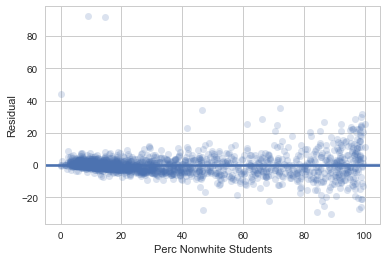

In [877]:
re = sns.regplot(x = df_staff_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

We looked at the 3 schools with residuals over 40 first. These three schools are extremely small, and two of them (which are housed in the same building) have nonwhite leaders.  

In [878]:
df_staff_15["Residuals"] = model.resid
outlier_mask = df_staff_15["Residuals"] > 40
df_staff_o = df_staff_15[outlier_mask]
df_staff_o

,Zip Code,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,...,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents,In Boston,Residuals
252,01257,7650015,Southern Berkshire: Monterey,Public School,2015,All Staff,0.0,6,1.0,2.2,...,45.454545,False,47167.0,27.6,90.5,33.2,97.5,2.5,Not Boston,44.346701
325,01440,7550515,Ralph C Mahar: Pathways Early College Innovati...,Public School,2015,All Staff,3.0,34,0.1,0.1,...,100.000000,True,43818.0,26.8,84.3,16.4,90.0,10.0,Not Boston,92.301124
326,01440,7550525,Ralph C Mahar: The Gateway to College,Public School,2015,All Staff,10.0,68,0.1,0.1,...,100.000000,True,43818.0,26.8,84.3,16.4,90.0,10.0,Not Boston,91.540076


In [879]:
df_staff_15_check = df_staff_15[~outlier_mask]

The school leader variable 

In [880]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + perc_pov + hs_grad + total_stu + zip_nonwhite",
              data = df_staff_15_check.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     872.0
Date:                Thu, 30 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:33:51   Log-Likelihood:                -5743.8
No. Observations:                1794   AIC:                         1.151e+04
Df Residuals:                    1785   BIC:                         1.156e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.7379      3.156     -2.769      0.006     -14.927      -2.548
nw_sl[T.True]                 4.5074      0.434     10.377      0.000       3.655       5.359
org_type[T.Public School]    -1.3969      0.738     -1.893      0.059      -2.844       0.050
in_boston[T.Boston]          25.2581      0.662     38.170      0.000      23.960      26.556
nw_stu                        0.1579      0.010     15.157      0.000       0.137       0.178
perc_pov                      0.0232      0.023      1.028      0.304      -0.021       0.068
hs_grad                       0.0979      0.031      3.145      0.002       0.037       0.159
total_stu                    -0.0011      0.000     -2.679      0.007      -0.002      -0.000
zip_nonwhite                  0.0757      0.016      4.791      0.000       0.045       0.107
==============================================================================
Omnibus:                      394.548   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3588.243
Skew:                           0.764   Prob(JB):                         0.00
Kurtosis:                       9.758   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, we reran our regression for schools with over 50% nonwhite students to see if the same variable contribute to the percentage of nonwhite staff. 

In [ ]:
overhalf_mask = df_staff_15["Perc Nonwhite Students"] > 50.0
df_overhalf = df_staff_15[overhalf_mask]

In [ ]:
## College grad becomes significant
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = df_overhalf.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

In [ ]:
re = sns.regplot(x = df_overhalf["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

In [ ]:
boston_mask = df_staff_15["In Boston"] == "Boston"
boston_15 = df_staff_15[boston_mask]

In [ ]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = boston_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

In [ ]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=boston_15, palette="Set2")
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

In [ ]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Students", data=boston_15, palette="Set2")
sl.set_ylabel('Percent Nonwhite Students', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

In [ ]:
re = sns.regplot(x = boston_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});